In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os 
import ee
import geemap
import os

In [ ]:



try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='ucl-Forest') 

In [ ]:


roi_point =ee.Geometry.Point([ -72.71, -40.86]) 
roi = roi_point.buffer(2500).bounds() 

start_date = '2016-01-01'
end_date = '2016-03-30'

def get_s2_composite(roi, start, end):
    """
    Fetches Sentinel-2 Surface Reflectance, filters clouds, 
    and returns a median composite.
    """
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate(start, end) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))


    bands = ['B4', 'B3', 'B2', 'B8']
    new_names = ['Red', 'Green', 'Blue', 'NIR']
    

    composite = s2.select(bands, new_names).median().clip(roi)
    

    return composite.unmask(0) 


s2_image = get_s2_composite(roi, start_date, end_date)


output_path = "./data/chile_gfc_data"
output_file = 'sentinel2_2014_chile_roi2.tif'

print("Starting download from Google Earth Engine...")
geemap.ee_export_image(
    s2_image,
    filename=os.path.join(output_path, output_file),
    scale=10,
    region=roi,
    file_per_band=False
)

print(f"Download Complete: {os.path.join(output_path, output_file)}")
print("You now have the exact input tensor (H, W, 4) required for the Attention U-Net paper.")

Starting download from Google Earth Engine...
Generating URL ...
An error occurred while downloading.
Image.unmask: If one image has no bands, the other must also have no bands. Got 0 and 1.
Download Complete: ./data/chile_gfc_data/sentinel2_2014_chile_roi2.tif
You now have the exact input tensor (H, W, 4) required for the Attention U-Net paper.


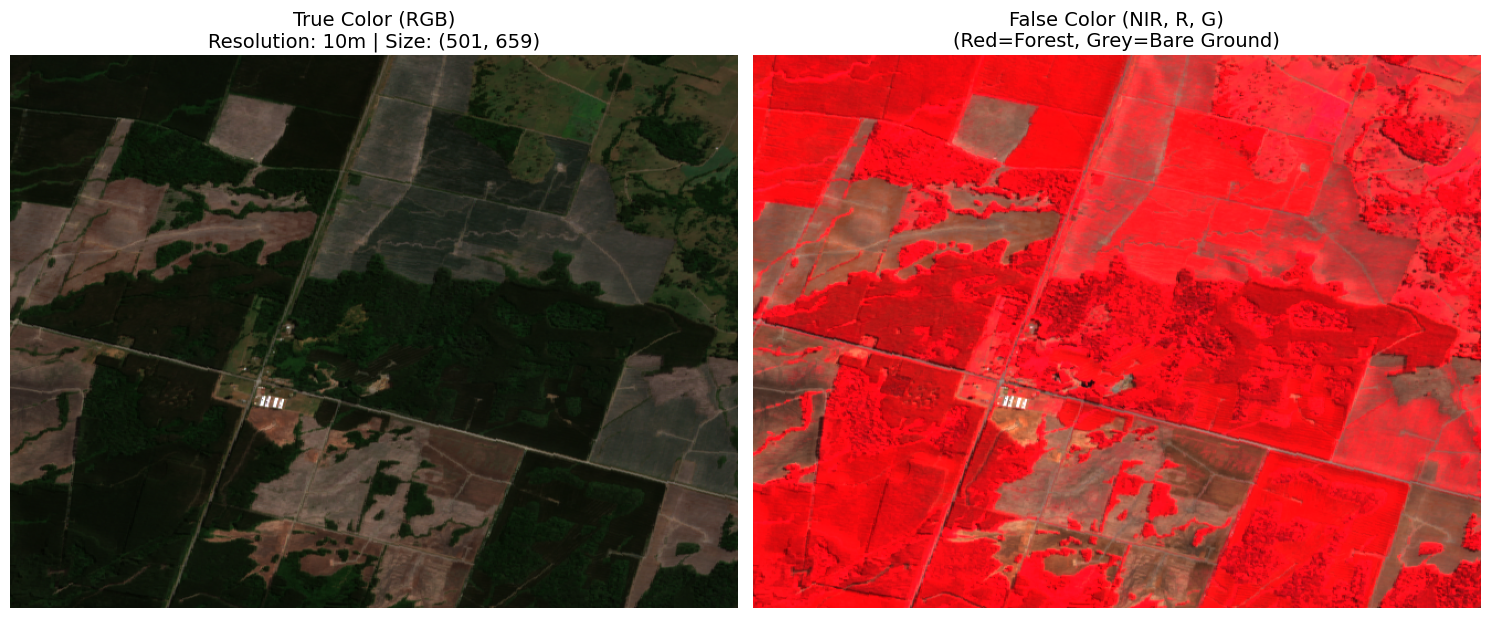

In [ ]:

sentinel_path = os.path.join("./data/chile_gfc_data", 'sentinel2_2024_chile_roi2.tif')

if not os.path.exists(sentinel_path):
    print(f"Error: File {sentinel_path} not found. Did the GEE export finish?")
else:
    def normalize(band):
        """Normalize Sentinel-2 (0-10000) to 0-1 range for display."""
        
        return np.clip(band / 3000.0, 0, 1)

    with rasterio.open(sentinel_path) as src:
        red   = src.read(1)
        green = src.read(2)
        blue  = src.read(3)
        nir   = src.read(4)

        rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))
        
        false_color = np.dstack((normalize(nir), normalize(red), normalize(green)))

        fig, ax = plt.subplots(1, 2, figsize=(15, 8))
        
        ax[0].imshow(rgb)
        ax[0].set_title(f"True Color (RGB)\nResolution: 10m | Size: {red.shape}", fontsize=14)
        ax[0].axis('off')
        
        ax[1].imshow(false_color)
        ax[1].set_title("False Color (NIR, R, G)\n(Red=Forest, Grey=Bare Ground)", fontsize=14)
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()

In [ ]:

roi_point = ee.Geometry.Point([-72.71, -40.86]) 
roi = roi_point.buffer(2500).bounds() 

start_date = '2018-01-01'
end_date = '2018-06-30'

def get_s2_robust(roi, start, end):
    """
    Robust fetcher that accepts cloudy images and uses Median 
    to remove the clouds statistically.
    """

    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate(start, end) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))

    count = s2.size().getInfo()
    print(f"Found {count} images (including cloudy ones) for the median composite.")
    
    if count == 0:
        raise ValueError("Still no images found! Try a different year (e.g., 2017) or check ROI.")

    bands = ['B4', 'B3', 'B2', 'B8']
    new_names = ['Red', 'Green', 'Blue', 'NIR']
    

    composite = s2.select(bands, new_names).median().clip(roi)
    
    return composite.unmask(0)


try:
    print(f"Searching for Sentinel-2 data in Chile ({start_date} to {end_date})...")
    s2_image = get_s2_robust(roi, start_date, end_date)

    # 4. Export
    output_path = "./data/chile_gfc_data"
    os.makedirs(output_path, exist_ok=True)
    output_file = 'sentinel2_2018_robust_composite.tif'
    full_path = os.path.join(output_path, output_file)

    print("Starting download...")
    geemap.ee_export_image(
        s2_image,
        filename=full_path,
        scale=10, 
        region=roi,
        file_per_band=False
    )
    print(f"Success! Saved to: {full_path}")
    print("Check this image. If it looks 'hazy', the year 2016 might be too difficult for this region.")

except Exception as e:
    print(f"CRITICAL ERROR: {e}")

Searching for Sentinel-2 data in Chile (2018-01-01 to 2018-06-30)...
Found 3 images (including cloudy ones) for the median composite.
Starting download...
Generating URL ...
Please wait ...
Data downloaded to /home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/chile_gfc_data/sentinel2_2016_robust_composite.tif
Success! Saved to: ./chile_gfc_data/sentinel2_2016_robust_composite.tif
Check this image. If it looks 'hazy', the year 2016 might be too difficult for this region.


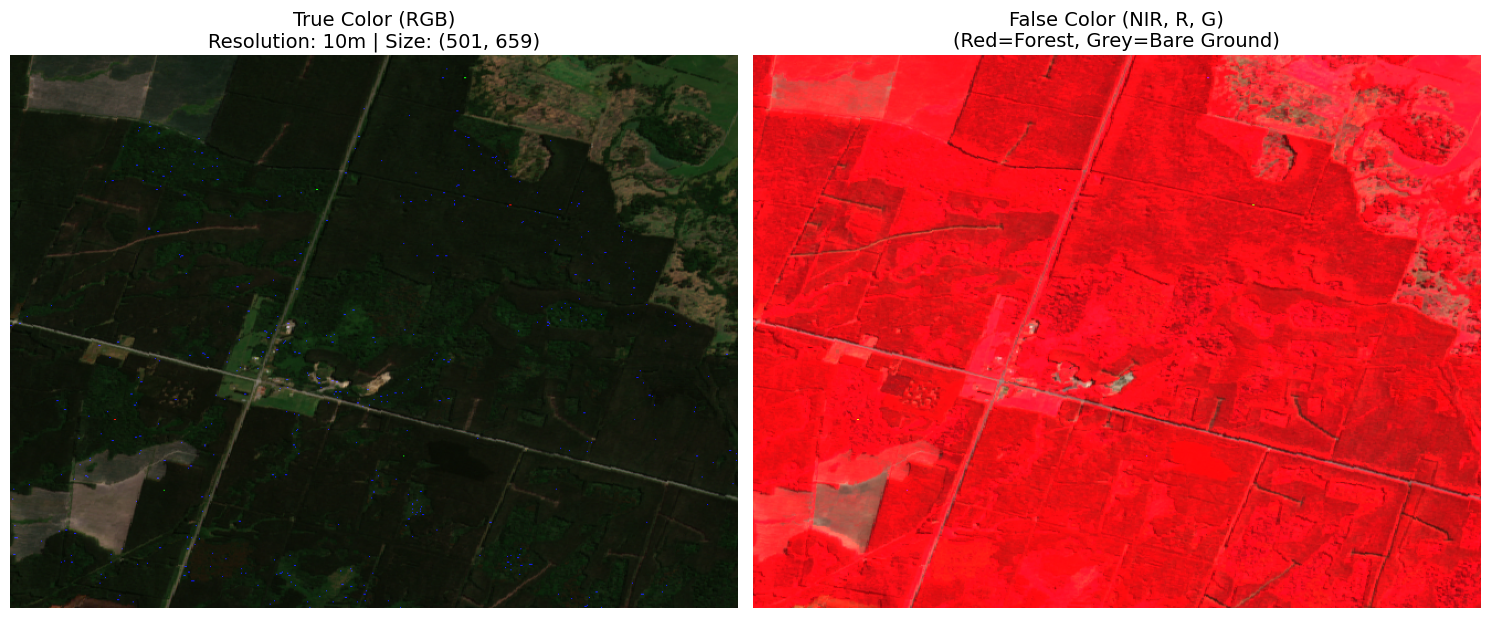

In [ ]:

sentinel_path = os.path.join("./data/chile_gfc_data", 'sentinel2_2016_robust_composite.tif')

if not os.path.exists(sentinel_path):
    print(f"Error: File {sentinel_path} not found. Did the GEE export finish?")
else:
    def normalize(band):
        """Normalize Sentinel-2 (0-10000) to 0-1 range for display."""

        return np.clip(band / 3000.0, 0, 1)

    with rasterio.open(sentinel_path) as src:

        red   = src.read(1)
        green = src.read(2)
        blue  = src.read(3)
        nir   = src.read(4)
        

        rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))
        
 
        false_color = np.dstack((normalize(nir), normalize(red), normalize(green)))

        # Plot
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))
        
        ax[0].imshow(rgb)
        ax[0].set_title(f"True Color (RGB)\nResolution: 10m | Size: {red.shape}", fontsize=14)
        ax[0].axis('off')
        
        ax[1].imshow(false_color)
        ax[1].set_title("False Color (NIR, R, G)\n(Red=Forest, Grey=Bare Ground)", fontsize=14)
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()